# Snake Eyes Dungeon study

*Snake Eyes Dungeon* is a relatively simple game, but also a great exercise in understanding statistics, probabilities, and even Markov chains.

This notebook is my own exploration of the game under such theoretical analysis. I'm not following a pure theoretical approach, though. I'm mixing my knowledge of the theory with a practical simulation of the possible game states. This simulation, however, isn't too far off from the theory itself.

## Introduction and game rules

*Snake Eyes Dungeon* is a video-game created by [Facundo Mounes][newgrounds] and available [on Steam][steam] and [on GameJolt][gamejolt]. It seems it was previously available on iOS and Google Play, but those versions are not found anymore.

[steam]: https://store.steampowered.com/app/740240/Snake_Eyes_Dungeon/
[gamejolt]: https://gamejolt.com/games/snake-eyes-dungeon/147564
[newgrounds]: https://facundomounes.newgrounds.com/

In *Snake Eyes Dungeon*, all the rules are clearly explained to the user, and there is no hidden state. Thus, it would be possible to play this game with just pen and paper and a couple of dice.

Sidenote: Some upgrades have "hidden" effects. For instance, one upgrade increases the probability of getting 1-1 on the dice, but it is not explained if this only affects "attacking" rolls or all rolls, and the increased probability isn't shown either. For simplicity, we can ignore these optional hidden modifiers.

### Materials needed

Get two six-sided dice. Or just one, but then you have to roll it twice every time.

Get a piece of paper and make a 6×6 grid of squares.

Get something to represent the player on top of this 6×6 grid. It can be a token or a coin.

Either reserve some space on (another) piece of paper, or get several tokens for tracking stats:

* Player HP (Health Points), which starts at 25 and goes down to zero.
* Enemy HP, which goes up to 35.
* Inventory:
    * Keys (maximum of one key; so essentially it is a yes/no state)
    * Bombs (starts at zero, and it's unlikely to collect more than a handful)
    * Potions (starts at zero, and it's unlikely to collect more than a handful)
    * Coins (can go up to hundreds)

### Rules overview

Each game plays like this:

```mermaid
graph LR
  P([Preparation]) --> D[Dungeon exploration]
  D --> D
  D --> E[Enemy encounter]
  E --> D
  E --> L[[Game over]]
  D --> V[[Victory]]
```

This graph may have a weirdly-shaped arrow due to [this Mermaid bug](https://github.com/mermaid-js/mermaid/issues/5820).

### Preparation

Each game explores a completely new random dungeon. These are the steps needed to prepare the beginning of each game.

1. Set the Player HP to 25. (Or higher, if you have purchased health upgrades. Higher will make the game easier.) During a game, it is impossible to go beyond this initial value.
3. Set Bombs and Potions to zero. (Or one, if you have purchased a starting item.)
4. Set the Key to zero, i.e. not yet found.
5. Set the Coins to zero. (These are the coins you collected in the current dungeon. This amount is independent from the overall coins across multiple dungeons.)
6. Set all 6×6 grid cells to "Unexplored".
7. Determine the exit cell.
    1. Roll the dice. (All dice rolls in this game are always two six-sided dice.)
    2. The leftmost die is the X position, the rightmost die is the Y position.
    3. Mark the X×Y cell as "Exit".
8. Determine the starting position.
    1. Roll the dice.
    2. The leftmost die is the X position, the rightmost die is the Y position.
    3. Mark the X×Y cell as "Empty room".
    4. Put the player token on this cell.

Now the game is set and ready to start. The objective of the player is to explore the dungeon, find a key, and exit.

### Dungeon exploration

If the player has enough coins, the player can choose to buy some items:

* Buy a bomb for 50 coins. (Only possible if there are no bombs in the inventory. Potions can only be used during enemy encounters.)
* Buy a potion for 40 coins. (Only possible if there are no potions in the inventory. Potions can only be used during enemy encounters.)
* Buy a key for 150 coins. (Only possible if the player hasn't yet collected the key.)

Given the current player location, the player can try moving to one of the four adjacent cells: top, right, bottom, or left. Some of these directions may not be available:

* The player cannot go out-of-bounds, i.e. the player cannot go outside the 6×6 grid.
* The movement is impossible (blocked) if the desired adjacent cell is a destroyed room.

The player must choose one of the valid destinations. Then the player token is moved to that cell.

#### Unexplored destination

If the destination cell is still "Unexplored", then roll the dice. The sum of the dice values determines what should happen to this cell:

| Sum | Enemy? | Event          |
| --: | ------ | :------------- |
|   2 |        | Key            |
|   3 |        | Teleport       |
|   4 | Enemy  | Frankenstein   |
|   5 |        | Destroyed room |
|   6 | Enemy  | Mummy          |
|   7 | Enemy  | Ghost          |
|   8 | Enemy  | Werewolf       |
|   9 |        | Empty room     |
|  10 | Enemy  | Fairy          |
|  11 | Enemy  | Vampire        |
|  12 |        | 5 HP           |


* **Empty room**
    * Mark the cell as "Empty room".
* **Key**
    * Mark the Key as collected in the inventory.
    * If the player already had a key, this room has no effect.
    * Mark the cell as "Empty room".
    * Optionally, you can draw a chest on this cell, but it behaves as an empty room.
    * When opening the last unexplored cell of the game (i.e. the 36th cell), it is guaranteed to find a key in there.
* **5 HP**
    * Increase the Player HP by 5 points, capped to the starting HP value. In other words, it's impossible to go over the initial HP amount.
    * Mark the cell as "Empty room".
    * Optionally, you can draw a water fountain on this cell, but it behaves as an empty room.
* **Destroyed room**
    * Mark the cell as "Destroyed room".
    * You can draw a pit, a wall, or even a large "X" on this cell.
    * Once the player leaves this cell, it is not possible to walk back onto it.
* **Teleport**
    * Mark the cell as "Empty room".
    * The player token must now be moved to another cell. One of the unexplored cells is chosen at random.
    * Roll the dice again, as if the player had just moved that unexplored cell.
* **Enemy**
    * Mark the cell as "Enemy".
    * Starts an enemy encounter.

After these actions, the "Dungeon exploration" phase restarts. (Unless there is an enemy encounter.)

#### Previously explored destination

If the destination cell has already been explored:

* **Empty room**
    * The player can freely move here, and nothing happens.
* **Destroyed room**
    * This cannot happen. The player cannot move here.
    * If somehow the player is here, it behaves as an empty room, but the player cannot come back here later.
* **Exit**
    * If the player has collected the Key, then we have reached the Victory condition. The amount of coins in the inventory is added to the "bank", to the overall total of collected coins. This amount can be used to buy upgrades before starting another game.
    * If the player doesn't have the Key, then this behaves as an empty room.
* **Enemy**
    * Starts the enemy encounter, again.

After the movement, the "Dungeon exploration" phase restarts. (Unless there is an enemy encounter or a victory condition.)

### Enemy encounter

When the player steps onto a cell containing an enemy, the game switches to a combat scene. The player and the enemy alternately take turns, starting with the player.

#### Player turn

At the start of the player's turn, the player can choose to use one or more of the items in the inventory:

* **Bomb** will insta-kill the enemy, dealing massive damage and reducing the enemy HP to zero. This will end the fight and proceed with the Loot phase.
* **Potion** will heal the player 7 points. This will increment the Player HP up to the starting value. Multiple potions can be used. A bomb can be used after using potions.

The player can also choose not to use any item.

Afterwards, the player another choice: Fight or Escape. This choice is mandatory to progress the game, and will end the player's turn.

##### Escape

The player is trying to escape.

1. Roll the dice an sum the values.
2. If the sum of the dice is among any of the values that allows the player to escape this enemy, then the player successfully escaped.
    * The enemy encounter ends, and we go back to dungeon exploration.
    * No loot is collected.
    * The enemy has not been defeated, and it is still alive. Thus, the grid cell is still marked as "Enemy". The player can move to any adjacent cell as normal, but returning to this cell will re-trigger the enemy encounter.
3. Otherwise, if the escape attempt has failed, the enemy turn starts.

Some enemies are too strong and can't be escaped from.

##### Fight

The player decided to fight the enemy.

1. Roll the dice and sum the values.
2. If the sum is 2 (i.e. each dice has "one", which is called *snake eyes*), and if the enemy is vulnerable to snake-eyes…
    * Reduce the enemy HP to zero.
    * The enemy has been defeated. Proceed with the Loot phase.
3. If the enemy isn't vulnerable to snake-eyes, or if the sum isn't 2…
    * The player attack has the same strength as the sum of the dice. (Plus any attack upgrades, but we are going to ignore any upgrades in this description.)
    * Decrease the Enemy HP by the player attack value.
    * If the Enemy HP is zero or lower, the enemy has been defeated. Proceed with the Loot phase.
4. If the enemy is still alive after the player attack…
    * It is now time to start the enemy turn.

#### Loot phase

If the enemy has been defeated, the player can collect loot.

Roll the dice. The sum of the dice values determines what loot is received. Each enemy has a different table mapping values to loot.

Most likely, the player will either receive some health (in fixed amounts), or receive coins. While the amount of health points is fixed and depends on the dice roll, the amount of coins is random and calculated independently from the dice roll value.

Some enemies can give a Key as loot. The the user already has a key, then the player receives HP instead.

Some enemies can give either a Bomb or a Potion. Those get added to the inventory, even if the player is already carrying one or more of them.

The Fairy can give an Artifact. Artifacts are permanent across plays. Once given an artifact, it's immediately and permanently unlocked, even if the player dies in the current dungeon. Before the start of any game, the player can choose one, and only one, artifact to be enabled.

After the loot is collected, we go back to dungeon exploration.

#### Enemy turn

For most enemies, their turn is very simple. They deal a constant amount of damage per turn.

1. Subtract the Enemy Attack from the Player HP.
2. If the Player HP is zero or lower, the player has been defeated. It's Game Over. Any collected coins in this dungeon are lost.
3. If the Player is still alive, it is now time for the player turn.

However, the Vampire enemy has a special behavior. The Vampire also has a pair of dice, which get rolled at the beginning of the turn. The sum of the dice determines what the Vampire will do. Afterwards, if the player is still alive, it's time for the player turn.

### Observations

This concludes the description of the whole game.

There is a lot of randomnes involved in the game. The following actions are essentially luck-based:

* Starting and ending positions in the dungeon grid.
* Room exploration.
* Player attack strength to the enemy.
* Vampire's attacks and turns.
* Collected loot after each enemy defeat.
* Being able to escape from an enemy encounter.

The following actions are governed by player choices:

* Which direction to move in the dungeon grid, and thus how many rooms will be visited.
* Decision to buy items, when enough coins are collected.
* Decision to use items in-battle.
* Decision to either escape or fight. (Although the actual outcome is luck-based.)

Given this knowledge, we can use probabilities and statistics to figure out how likely the player can succeed or fail in each of the steps. And given we have computers, we can mix theoretical knowledge with computer simulations, as well as letting the computer do all the required arithmetic calculations.

## Overview of this notebook

This notebook started as a completely unstructured exploration of the game. Later, I wrote down the introduction (above) and tried to add more structure to the contents, to make them easier to follow.

Still, this isn't a static notebook. Well, if you're reading this right now, it probably is still static… But what I mean is: this notebook is an open invitation to explore a world of probabilities of dice rolls applied to a (video-)game. It's a bridge from the (potentially) abstract theory from Math books to the tangible results of a game session.

If you decide to accept such invitation, [install and get started with Jupyter](https://docs.jupyter.org/en/latest/#where-do-i-start), and then open this notebook in it. You'll be able to mmodify the code and write your own code. You can explore the effects of changing some of the parameters, and you can try creating your own enemies and your own rules. How would such changes impact the gameplay? You can find the answers yourself. Have fun!

Most of the theory needed comes from the probability fundamentals learned from high school Math classes. For further understanding of the theory, please consider reading books and articles or joining classes about Probability and Statistics. Here are some suggestions:

* https://en.wikiversity.org/wiki/Fundamentals_of_probability_and_statistics
* https://en.wikiversity.org/wiki/Statistics
* https://en.wikibooks.org/wiki/Statistics
* https://en.wikibooks.org/wiki/Probability

## Main code

### Importing libraries

In [39]:
import math
from collections import Counter, defaultdict, namedtuple
from dataclasses import dataclass
from fractions import Fraction
from itertools import chain, groupby, zip_longest
from textwrap import dedent
from typing import Callable, Self

# https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.HTML
# https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display
from IPython.display import display, HTML

# pip install tqdm
from tqdm.notebook import tqdm

# pip install matplotlib
import matplotlib.pyplot as plt

In [2]:
# The built-in Fraction type is great, but doesn't have any special rendering inside a Jupyter notebook.
# Look:
Fraction(1, 2)

Fraction(1, 2)

In [3]:
# Let's make it pretty.

# Let's add an HTML rendering using MathML:
Fraction._repr_html_ = lambda self: '<math> <mfrac> <mn>{}</mn> <mn>{}</mn> </mfrac> </math>'.format(self.numerator, self.denominator)

# If for some reason MathML isn't desired or supported,
# we could add a plain HTML rendering using superscript and subscript,
# separated by the Fraction Slash character from Unicode.
#Fraction._repr_html_ = lambda self: '<sup>{}</sup>\u2044<sub>{}</sub>'.format(self.numerator, self.denominator)

# Alternatively, we could add a LaTeX rendering.
# I tried it, but it ended up inferior to the other solutions.
#Fraction._repr_latex_ = lambda self: r'$\frac{%d}{%d}$' % (self.numerator, self.denominator)

In [4]:
# Look how prettier it is now:
Fraction(1, 2)

Fraction(1, 2)

### Dice probabilities

I'm taking some shortcuts in this code.

To make the code completely flexible and supporting multiple kinds of dice, and potentially more than two dice, I would have to structure this code in a more complicaded way. This would require more code and more care, making the overall code more verbose.

Instead, I'm not doing any of that.

Throughout this entire notebook, I'm assuming I have exactly two dice, each one with 6 sides (going from 1 to 6). That means all the tables (i.e. lists or arrays) have exactly 11 elements, going from 2 to 12.

Exploring the effects of different kinds of dice is interesting, but will require major refactoring of the code. This exploration is left as an exercise for the interested reader.

In [5]:
# All possible dice rolls (i.e. sum of two dice):
DICEROLLS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# And the probability of each dice roll:
DICEPROB = [Fraction(i, (6*6)) for i in [1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1]]

Indeed, we can verify that the sum of probabilities is exactly 1.0:

In [6]:
assert sum(DICEPROB) == 1

#### Exploring how the probabilities were calculated

(Note: This section is completely optional. It goes on an tangent, but has no real impact on the rest of the code.)

These probabilites are hard-coded based on the sum of two dice.

We can easily see the distribution of the sum of two dice with the following code. Most of this code is just to render the fancy HTML tables, as the actual math is pretty trivial.

In [7]:
class DiceProbabilitiesAnalysis:
    def __init__(self, a=[1, 2, 3, 4, 5, 6], b=[1, 2, 3, 4, 5, 6]) -> None:
        self.a = sorted(a)
        self.b = sorted(b)
        # Precomputing all the sums.
        self.rolls = [x + y for x in a for y in b]

        # Precomputing colors.
        values = sorted(set(self.rolls))
        self.colors = {
            value: 'oklch(100% 33% {})'.format(i * 360 / len(values))
            for (i, value) in enumerate(values)
        }
    def html_sum_table(self) -> str:
        return '\n'.join([
            '<div style="--cell-size: 4ch; margin: calc(var(--cell-size) * {} * 0.4142 / 2)">'.format(1 + max(len(self.a), len(self.b))),
            dedent('''<style>
            @scope {
              /* All those !important flags are to override Jupyter's built-in styles. */
              table {
                border-collapse: separate !important;
                border-spacing: 0.5px !important;
                border: 0 !important;
                transform: rotate(45deg);
              }
              tr {
                background: transparent !important;
              }
              td, th {
                width: var(--cell-size) !important;
                height: var(--cell-size) !important;
                padding: 0 !important;
                border: 0 !important;
                text-align: center !important;
                vertical-align: middle !important;
              }
              td > div, th > div {
                transform: rotate(-45deg);
              }
            }</style>'''),
            '<table>',
            '<tr>',
            '<th><div>+</div></th>',
            *['<th scope="col"><div>{}</div></th>'.format(x) for x in self.a],
            '</tr>',
            *chain.from_iterable(
                [
                    '<tr>',
                    '<th scope="row"><div>{}</div></th>'.format(y),
                    *[
                        '<td style="color: black; background: {color}"><div>{sum}</div></td>'.format(
                            color=self.colors[x + y],
                            sum=x + y,
                        ) for x in self.a
                    ],
                    '</tr>',
                ]
                for y in self.b
            ),
            '</table>',
            '</div>',
        ])
    def html_probability_table(self) -> str:
        count = Counter(self.rolls)
        population = len(self.rolls)
        return '\n'.join([
            '<table>',
            '<tr>',
            '<th scope="col">Sum</th>',
            '<th scope="col">Prob.</th>',
            '<th scope="col">Perc.</th>',
            '<th scope="col">Bar graph</th>',
            '</tr>',
            *chain.from_iterable(
                [
                    '<tr>',
                    '<th style="text-align: right;" scope="row">{}</th>'.format(value),
                    '<td style="text-align: center;">{}</td>'.format(Fraction(qty, population)._repr_html_()),
                    '<td style="text-align: right;">{:.1f}%</td>'.format(100 * qty / population),
                    '<td style="text-align: left;">{}</td>'.format('█' * qty),
                    '</tr>',
                ]
                for (value, qty) in sorted(count.items())
            ),
            '</table>',
        ])
    def _repr_html_(self) -> str:
        return '\n'.join([
            '<div style="display: flex; flex-direction: row; align-items: center; gap: 1em;">',
            self.html_sum_table(),
            self.html_probability_table(),
            '</div>',
        ])

With that code, we can easily see the distribution of the sums of two 6-sided dice:

In [8]:
DiceProbabilitiesAnalysis()

But we can also have fun exploring other dice. What if these were 8-sided dice?

Well, that's just like the previous example, just bigger.

In [9]:
DiceProbabilitiesAnalysis(range(1, 9), range(1,9))

And what if the 6-sided dice had different numbers on them? Let's imagine both dice the numbers 3 or 4 replaced by another 1.

In [10]:
DiceProbabilitiesAnalysis([1, 2, 1, 4, 5, 6], [1, 2, 3, 1, 5, 6])

And what if we remove both 3 and 4 and replace them with another 1 and 6?

In [11]:
DiceProbabilitiesAnalysis([1, 2, 1, 6, 5, 6], [1, 2, 1, 6, 5, 6])

This kind of exploration can be done using pen-and-paper, but having a computer with an interactive notebook makes it easy and quick to observe the outcomes of different scenarios.

Regardless of how fun these are, the *Snake Eyes Dungeon* game uses two standard 6-sided dice, and that's what we are going to use in the rest of this notebook.

### Basic data structures

In this section, a few convenient data structures are defined. Not only they assist the main simulation code, but they also provide a pretty human-friendly visualization using a markdown table.

#### State

The majority of the gameplay happens in enemy encounters. For simulating those and calculating probabilities, we need a way to represent the game state.

The simplest way to represent state is by tracking the Player HP and the Enemy HP, and nothing else. Bombs don't matter, as using them will insta-kill an enemy. Potions can be simulated by adding 7 to the Player HP, even if that means going over the starting limit. Coins and keys don't matter while fighting an enemy.

Thus, the `State` type is an immutable pair (tuple) of two (integer) numbers. Being immutable makes it hash-able, and thus it can be used as keys of `dict` objects.

In [12]:
State = namedtuple('State', ['enemy', 'player'])

#### Distributions

The results of simulations, as well as the results of dice rolls, can be represented as a distribution of states/outcomes and their corresponding probability.

Thus, we have a `ThingDistribution` base class. It's derived from `defaultdict`, which means it behaves just like a normal `dict`.

Since it's a `defaultdict`, it also means that any non-existing key will return `Fraction()`, which is equivalent to `Fraction(0, 1)`, which just means zero. In other words, any new/unknown/undiscovered state has zero probability of being there. Even though this sounds meaningless, it greatly simplifies the code because it allows us to just add up fractions without having to worry about non-existent keys.

The `ThingDistribution` is a mutable data structure. It gets built gradually, step-by-step, usually inside a loop exploring all the possible states.

The most interesting aspect of this data structure is its ability to render itself in a nice human-readable table inside this Jupyter notebook.

In [37]:
class ThingDistribution(defaultdict):
    _headers   = ['Thing']
    _alignment = ['left' ]
    _getters   = [
        lambda x: x,
    ]
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(Fraction, *args, **kwargs)

    def __repr__(self) -> str:
        return '{}({})'.format(self.__class__.__name__, dict.__repr__(self))

    @property
    def _all_headers(self) -> list[str]:
        return self._headers   + ['Percent', 'Probability']
    @property
    def _all_alignment(self) -> list[str]:
        return self._alignment + ['right'  , 'center'     ]

    def copy_constructor(self):
        '''Returns a new instance of the same sub-class.'''
        return self.__class__()

    def other_constructor(self):
        '''Value for the bucket of items below the threshold.'''
        return '(other)'

    def threshold(self, threshold=Fraction(1, 1000)) -> Self:
        '''Returns a new distribution where all things with very small probability are grouped together.
        '''
        ret = self.copy_constructor()
        other = self.other_constructor()
        for thing, p in self.items():
            if p < threshold:
                ret[other] += p
            else:
                ret[thing] = p
        return ret

    def threshold_if_more_than(self, items: int) -> Self:
        '''Returns a threshold distribution if the current distribution has more
        than the specified amount of items. Otherwise returns itself unchanged.
        '''
        if len(self) > items:
            probs = sorted(self.values())
            return self.threshold(threshold=probs[-items])
        else:
            return self

    def _repr_html_(self) -> str:
        return '\n'.join([
            '<table>',
            '<thead>',
            '<tr>',
            *[
                '<th scope="col" style="text-align: center">{}</th>'.format(header)
                for header in self._all_headers
            ],
            '</tr>',
            '</thead>',
            '<tbody>',
            *chain.from_iterable(
                [
                    '<tr>',
                    *[
                        '<td style="text-align: {}">{}</td>'.format(align, value)
                        for (align, value) in zip(self._all_alignment, [
                            *[
                                func(thing) for func in self._getters
                            ],
                            format(p * 100, '.1f'),
                            p._repr_html_(),
                        ])
                    ],
                    '</tr>',
                ]
                for thing, p in sorted(self.items(), key=lambda item: (item[1], item[0]), reverse=True)
            ),
            '</tbody>',
            '</table>',
        ])

There are also a few subclasses, one for each specific result.

In [14]:
class LootDistribution(ThingDistribution):
    _headers   = ['Loot']

In [15]:
class GroupDistribution(ThingDistribution):
    def __init__(self, *args, group_name='Thing', **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.group_name = group_name

    @property
    def _headers(self) -> list[str]:
        return [self.group_name]

In [16]:
class RoomDistribution(ThingDistribution):
    _headers   = ['Content', 'Room']
    _alignment = ['center' , 'left']
    _getters   = [
        lambda x: str(x[0]),
        lambda x: str(x[1]),
    ]

    def group_distribution(self) -> GroupDistribution:
        group = GroupDistribution(group_name='Content')
        for (content, room), p in self.items():
            group[content] += p
        return group

In [38]:
class StateDistribution(ThingDistribution):
    #_headers  = ['Player', 'Δ HP' , 'Enemy', 'Δ HP' , 'Outcome']
    _alignment = ['right' , 'right', 'right', 'right', 'left'   ]

    def __init__(self, *args, player_name='Player', enemy_name='Enemy', player_hp=0, enemy_hp=0, action='attack', **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.player_name = player_name
        self.enemy_name = enemy_name
        self.player_hp = player_hp
        self.enemy_hp = enemy_hp
        self.action = action

    def copy_constructor(self):
        '''Returns a new instance of the same sub-class.'''
        return self.__class__(
            player_name=self.player_name,
            enemy_name=self.enemy_name,
            player_hp=self.player_hp,
            enemy_hp=self.enemy_hp,
            action=self.action,
        )

    def other_constructor(self):
        return State('?', '?')

    @property
    def _headers(self) -> list[str]:
        return [self.player_name, 'Δ HP', self.enemy_name, 'Δ HP', 'Outcome']

    @property
    def _getters(self) -> Callable[[State], str]:
        return [
            lambda x: str(x.player),
            lambda x: str(x.player - self.player_hp) if x.player != '?' else '?',
            lambda x: str(x.enemy),
            lambda x: str(x.enemy - self.enemy_hp) if x.player != '?' else '?',
            lambda x: self.state_outcome(x),
        ]

    def state_outcome(self, st: State) -> str:
        if st.player == 0:
            return '{} is dead'.format(self.player_name)
        elif st.enemy == 0:
            if self.action == 'attack':
                return '{} is dead'.format(self.enemy_name)
            elif self.action == 'escape':
                return '{} has escaped'.format(self.player_name)
            else:
                raise ValueError('Unsupported action {!r}'.format(action))
        elif st.player == '?' or st.enemy == '?':
            return '(other)'
        else:
            return 'Both still alive'

    def group_distribution(self) -> GroupDistribution:
        group = GroupDistribution(group_name='Outcome')
        for st, p in self.items():
            group[self.state_outcome(st)] += p
        return group

##### Using Distribution classes

Using them should be simple. Look at these examples:

In [18]:
# We can initialize the distribution with a dict, if we already have one.
example_distribution = ThingDistribution({
    'foo': Fraction(1, 5),
    'bar': Fraction(1, 5)
})
example_distribution

Thing,Percent,Probability
foo,20.0,1 5
bar,20.0,1 5


In [19]:
# The distribution is mutable, and we will often build it step-by-step in a loop.
for value in ['foo', 'bar', 'baz']:
    example_distribution[value] += Fraction(1, 5)
example_distribution

Thing,Percent,Probability
foo,40.0,2 5
bar,40.0,2 5
baz,20.0,1 5


Pretty much the same usage applies to all sub-classes. 

### Room types

We have 11 room types.

In [20]:
ROOMS = [
    ('item'   , 'Key'),
    ('nothing', 'Teleport'),
    ('enemy'  , 'Frankenstein'),
    ('nothing', 'Destroyed room'),
    ('enemy'  , 'Mummy'),
    ('enemy'  , 'Ghost'),
    ('enemy'  , 'Werewolf'),
    ('nothing', 'Empty room'),
    ('enemy'  , 'Fairy'),
    ('enemy'  , 'Vampire'),
    ('item'   , '5 HP'),
]

We will explore their probabilities further down.

### Enemy base class

All the enemies behave the same way, so we can have a base class `Enemy` containing all the logic, while each sub-class just changes the values. Well, the Vampire has different attacks (or actions), but that can be implemented as a superset of the simple attacks of the other enemies. This way, the exact same code applies to all enemies.

In fact, these classes don't hold any state, and thus it makes no sense to create instances of them.

This is the most important class from this notebook, as it implements a simulation of the game logic.

In [21]:
class Enemy:
    def __init__(self) -> None:
        raise NotImplementedError('There is no reason to create an instance of this class.');

    @classmethod
    def escape_probability(cls) -> Fraction:
        '''Returns the probability of being able to escape from this enemy.

        The probability is returned as a Fraction because DICEROLLS is a list of Fraction objects.
        '''
        return sum(DICEPROB[i] for (i, v) in enumerate(DICEROLLS) if v in cls.ESCAPE)

    @classmethod
    def loot_probability(cls) -> LootDistribution:
        '''Returns the probability of getting each kind of loot.
        '''
        lootmap = LootDistribution()
        for i, loot in enumerate(cls.LOOT):
            lootmap[loot] += DICEPROB[i]
        return lootmap

    @classmethod
    def enemy_attacks(cls) -> list[tuple]:
        '''Returns a list of tuples of all possible enemy attacks per turn.

        Each tuple has three values:
        - Attack strength, or how much it will damage the player.
        - Health regeneration, or how many health points the enemy will recover.
        - Probability, as a Fraction.
        '''
        if cls.ATK is not None:
            return [(cls.ATK, 0, Fraction(1,1))]
        else:
            return [
                (at, hp, p) for (at, hp), p in zip(cls.ATTACKS, DICEPROB)
            ]

    @classmethod
    def simulate_actions(cls, steps=10, player_hp=25, extra_attack=0, action=None) -> StateDistribution:
        '''Simulate repeated player actions and calculate the probability of all possible outcomes.

        Parameters:
        - `steps`: Limit the simulation to at most this amount of steps.
                   The simulation will stop early if all states have
                   been explored and no new states are possible.
        - `player_hp`: Initial Player HP for this enemy encounter.
        - `extra_attack`: Adds this constant number to all player attacks.
                          This essentially makes the player stronger,
                          and it is one of the available upgrades in the game.
        - `action`: See description below.

        Actions: 'attack' or 'escape'
        The simulation will repeat the same action at all turns.

        The simulation assumes the player will decide an approach at the
        beginning of the enemy encounter and will not change the approach
        until the end of the encounter. Although it this may sound limiting,
        it's actually a good strategy. Changing actions mid-fight means the
        previous turns were wasted (and thus HP was wasted) trying something
        that is not the final objective of this particular encounter.
        '''

        metadata = {
            'enemy_name': cls.__name__,
            'player_hp': player_hp,
            'enemy_hp': cls.HP,
            'action': action,
        }

        # The enemy encounter always starts in a deterministic way:
        # both the Enemy HP and the Player HP are known with 100% certainty.
        states = StateDistribution({
            State(enemy=cls.HP, player=player_hp): Fraction(1, 1),
        }, **metadata)

        # tqdm will show a nice progress bar for each step taken by the simulation.
        # It will also show how many steps were required before the simulation aborted early.
        for step in tqdm(range(steps), desc='Simulating {} on {}'.format(action, cls.__name__)):
            old_states = states
            states = StateDistribution(**metadata)
            for st, stprob in old_states.items():
                if st.player <= 0 or st.enemy <= 0:
                    # Player or enemy are already dead.
                    states[st] += stprob
                else:
                    # Player is alive.
                    for i, prob in enumerate(DICEPROB):
                        player_dice_roll = DICEROLLS[i]
                        enemy_is_alive = True
                        if action == 'attack':
                            # Player tries to attack.
                            player_attack = player_dice_roll + extra_attack
                            if st.enemy - player_attack <= 0 or (cls.SNAKE_EYES_INSTAKILL and player_dice_roll == 2):
                                # Enemy is killed.
                                enemy_is_alive = False
                                new_state = State(enemy=0, player=st.player)
                                states[new_state] += prob * stprob
                        elif action == 'escape':
                            player_attack = 0
                            if player_dice_roll in cls.ESCAPE:
                                # Escaped! (represented as a dead enemy).
                                enemy_is_alive = False
                                new_state = State(enemy=0, player=st.player)
                                states[new_state] += prob * stprob
                        else:
                            raise ValueError('Unsupported action {!r}'.format(action))
                        if enemy_is_alive:
                            # Enemy plays a turn after the player turn.
                            # Enemy and player exchange attacks.
                            for enemy_attack, enemy_regen, enemy_prob in cls.enemy_attacks():
                                new_state = State(
                                    enemy=min(st.enemy - player_attack + enemy_regen, cls.HP),
                                    player=max(0, st.player - enemy_attack),
                                )
                                states[new_state] += prob * stprob * enemy_prob
            if all(st.enemy == 0 or st.player == 0 for st in states.keys()):
                # All the possible states have been explored. We can abort.
                break

        return states

    @classmethod
    def simulate_attacks(cls, *args, **kwargs) -> StateDistribution:
        return cls.simulate_actions(*args, **kwargs, action='attack')

    @classmethod
    def simulate_escapes(cls, *args, **kwargs) -> StateDistribution:
        return cls.simulate_actions(*args, **kwargs, action='escape')

### Enemies

Each of the enemies are implemented as straight-forward sub-classes of `Enemy`.

In [22]:
class Frankenstein(Enemy):
    # This becomes True if the player has leveled up the
    # "Extra Snake Eyes chances" upgrade at least to level 3 or 4.
    SNAKE_EYES_INSTAKILL = False
    HP = 28
    ATK = 4
    ESCAPE = {2, 7, 12}
    LOOT = [
        'Key or 10 HP',
        'Bomb',
        '$$$',
        '2 HP',
        '4 HP',
        '8 HP',
        '4 HP',
        '2 HP',
        '$$$',
        'Bomb',
        'Bomb',
    ]

In [23]:
class Mummy(Enemy):
    SNAKE_EYES_INSTAKILL = True
    HP = 15
    ATK = 3
    ESCAPE = {5, 6, 7, 8}
    LOOT = [
        'Bomb',
        '$$$',
        '$$$',
        '$$$',
        '2 HP',
        '6 HP',
        '2 HP',
        '$$$',
        '$$$',
        '$$$',
        '10 HP',
    ]

In [24]:
class Ghost(Enemy):
    SNAKE_EYES_INSTAKILL = True
    HP = 12
    ATK = 2
    ESCAPE = {5, 6, 7, 8, 9}
    LOOT = [
        '6 HP',
        '$$$',
        '$$$',
        '$$$',
        '2 HP',
        '4 HP',
        '2 HP',
        '$$$',
        '$$$',
        '$$$',
        '6 HP',
    ]

In [25]:
class Werewolf(Enemy):
    SNAKE_EYES_INSTAKILL = True
    HP = 21
    ATK = 4
    ESCAPE = {6, 7, 8}
    LOOT = [
        'Bomb',
        '$$$',
        '$$$',
        '2 HP',
        '4 HP',
        '8 HP',
        '4 HP',
        '2 HP',
        '$$$',
        '$$$',
        'Bomb',
    ]

In [26]:
class Fairy(Enemy):
    SNAKE_EYES_INSTAKILL = False
    HP = 7
    ATK = 7
    ESCAPE = set({})
    LOOT = [
        'Artifact or 10HP',
        '$$$',
        '$$$',
        'Potion',  # +7 HP
        'Potion',
        'Potion',
        'Potion',
        'Potion',
        '$$$',
        '$$$',
        'Artifact or 10HP',
    ]

In [27]:
class Vampire(Enemy):
    SNAKE_EYES_INSTAKILL = False
    HP = 35
    ATK = None
    ATTACKS = [
        # Attack, health regen
        (10, 0),
        (4, 0),
        (4, 0),
        (4, 0),
        (4, 0),
        (1, 3),
        (4, 0),
        (4, 0),
        (4, 0),
        (4, 0),
        (0, 12),
    ]
    ESCAPE = {2, 3, 11, 12}
    LOOT = [
        '10 HP',
        '$$$',
        '$$$',
        '4 HP',
        'Key or 10 HP',
        'Key or 10 HP',
        'Key or 10 HP',
        '4 HP',
        '$$$',
        '$$$',
        '10 HP',
    ]

In [28]:
# Secret boss. Can't be killed by bombs.
class Dragon(Enemy):
    SNAKE_EYES_INSTAKILL = False
    HP = 50
    ATK = 5
    ESCAPE = set({})
    LOOT = [
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
        '$$$',
    ]

In [29]:
ENEMIES = sorted([
    Frankenstein,
    Mummy,
    Ghost,
    Werewolf,
    Fairy,
    Vampire,
    Dragon,
], key=lambda x: x.HP)

In [30]:
ENEMIES_BY_NAME = { x.__name__: x for x in ENEMIES }

## Rooms: analysis and exploration

Let's look at the probability of getting each of the rooms.

In [31]:
room_dist = RoomDistribution(zip(ROOMS, DICEPROB))

In [32]:
room_dist.group_distribution()

Content,Percent,Probability
enemy,66.7,2 3
nothing,27.8,5 18
item,5.6,1 18


In [33]:
room_dist

Content,Room,Percent,Probability
enemy,Ghost,16.7,1 6
enemy,Werewolf,13.9,5 36
enemy,Mummy,13.9,5 36
nothing,Empty room,11.1,1 9
nothing,Destroyed room,11.1,1 9
enemy,Frankenstein,8.3,1 12
enemy,Fairy,8.3,1 12
nothing,Teleport,5.6,1 18
enemy,Vampire,5.6,1 18
item,Key,2.8,1 36


Let's try rendering that as a pie plot:

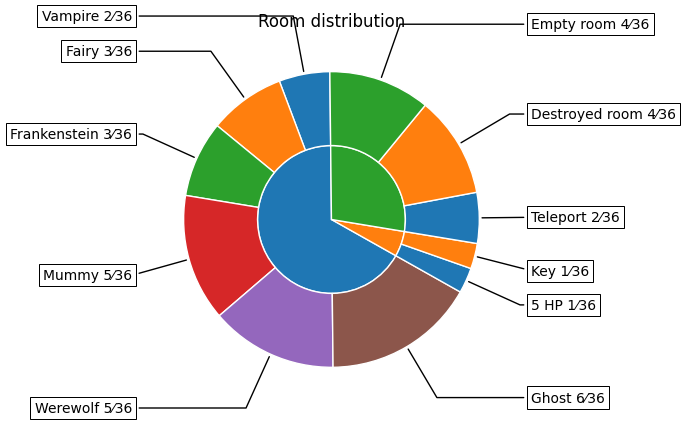

In [34]:
def nested_pie_plot(distribution: RoomDistribution, title: str):
    tuples = sorted([(a, b, p) for (a, b), p in distribution.items()], key=lambda x: (x[0], x[2], x[1]))
    individual_values = [p for a, b, p in tuples]
    group_values = [sum(p for a, b, p in group) for k, group in groupby(tuples, key=lambda x: x[0])]
    individual_colors = [
        'C{}'.format(i)
        for k, group in groupby(tuples, key=lambda x: x[0])
        for i, _ in enumerate(group)
    ]

    # Based on:
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/nested_pie.html
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    fig, ax = plt.subplots()
    size = 0.5
    startangle = 9.0625 * 360 / 36
    wedgeprops = dict(width=size, edgecolor='w')
    ax.pie(
        group_values,
        # colors=[v for k, v in sorted(colors.items())],
        radius=1 - size,
        startangle=startangle,
        wedgeprops=wedgeprops,
    )
    wedges, text = ax.pie(
        individual_values,
        colors=individual_colors,
        radius=1,
        startangle=startangle,
        wedgeprops=wedgeprops,
    )
    
    bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle='-'), bbox=bbox_props, zorder=0, va='center')
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2 + p.theta1
        y = math.sin(math.radians(ang))
        x = math.cos(math.radians(ang))
        horizontalalignment = 'right' if x < 0 else 'left'
        connectionstyle = f'angle,angleA=0,angleB={ang}'
        kw['arrowprops'].update({'connectionstyle': connectionstyle})
        ax.annotate(
            '{name} {numerator}\u2044{denominator}'.format(
                name=tuples[i][1],
                numerator=tuples[i][2].numerator * 36 // tuples[i][2].denominator,
                denominator=36,
            ),
            xy=(x, y),
            xytext=(1.35 * (-1 if x < 0 else 1), 1.4 * y),
            horizontalalignment=horizontalalignment,
            **kw,
        )
    
    ax.set(aspect='equal', title=title)
    plt.show()

nested_pie_plot(room_dist, title='Room distribution')

It's a somewhat nice plot, but also a bit confusing. Rendering as a nested pie plot was a good experiment, but I won't do it again. From here on, only plain tables will be used.

## Enemies: analysis and exploration

We have many kinds of enemies:

In [35]:
len(ENEMIES)

7

Most of them are randomly chosen when visiting a room, but the last enemy is the final boss of the game, and it only shows up when the player tries to exit the dungeon with over 700 gold coins.

Let's analyze all enemies. The exact same code is used for all of them.

The loot probabilities are the simplest to calculate and to understand, so the code starts by displaying those in a nice table. The actual amount of coins is random.

Next, the code explores what will happen if the player is scared and unconditionally tries to escape, over and over. Which is followed by the simulation of the opposite behavior: the player tries to attack, over and over.

The simulations in this code are written under the assumption the player will commit to either escape or attack, and will never change the strategy. This is arguably the best approach because:

* When escaping, it's the best strategy to maximize the chances of escaping and maximize the remaining player health.
* When attacking, it's the best strategy to maximize the damage done to the enemy, and thus to maximize the chances of defeating the enemy with the most amount of remaining player health.

When attacking, any (failed) escape attempt is equivalent as a no-damage attack, which is worse than the worst possible attack. When escaping, any attack is equivalent as a failed escape attempt.

These simulations are assuming a player with full health and no upgrades. Further down, we can study how upgrades and options can affect the outcome.

In [40]:
for enemy in tqdm(ENEMIES, desc="Enemies"):
    escapes = enemy.simulate_escapes()
    attacks = enemy.simulate_attacks()
    display(HTML('\n'.join([
        '<fieldset>',
        '<legend>{} simulations and probabilities</legend>'.format(enemy.__name__),
        '<h3>Loot from {}</h3>'.format(enemy.__name__),
        enemy.loot_probability()._repr_html_(),
        '<h3>Escaping from {}</h3>'.format(enemy.__name__),
        escapes.group_distribution()._repr_html_(),
        escapes.threshold_if_more_than(10)._repr_html_(),
        '<h3>Attacking {}</h3>'.format(enemy.__name__),
        attacks.group_distribution()._repr_html_(),
        attacks.threshold_if_more_than(20)._repr_html_(),
        '</fieldset>',
    ])))

Enemies:   0%|          | 0/7 [00:00<?, ?it/s]

Simulating escape on Fairy:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Fairy:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating escape on Ghost:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Ghost:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating escape on Mummy:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Mummy:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating escape on Werewolf:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Werewolf:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating escape on Frankenstein:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Frankenstein:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating escape on Vampire:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Vampire:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating escape on Dragon:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating attack on Dragon:   0%|          | 0/10 [00:00<?, ?it/s]

## Enemies: special analysis for special enemies

## Misc. (AKA TODO)

I can talk about:

* Bombs are not part of the simulation, because they are insta-kill.
* Potions are equivalent of having +7 (or multiples of +7) additional initial health.
* Explore the probability of survival (i.e. the group distribution) for each of the enemies.
* The effect of extra health and extra attack upgrades.
* Explain how Vampire has a long tail of states.

Homework (for the reader):

* Explore the "expected value" (esperança) of ΔHP.
* Combine the room probabilities with the enemy probabilities, and then explore how much HP is expected to be lost after "x" enemy encounters and after "x" rooms. This should also include the recovered HP from loot.
* Explore the probability of successful dungeon escape, assuming the player exits the dungeon as soon as the key is collected.

In [41]:
Frankenstein.simulate_attacks()

Simulating attack on Frankenstein:   0%|          | 0/10 [00:00<?, ?it/s]

Player,Δ HP,Frankenstein,Δ HP,Outcome,Percent,Probability
13,-12,0,-28,Frankenstein is dead,48.0,89525 186624
9,-16,0,-28,Frankenstein is dead,37.6,947569 2519424
5,-20,0,-28,Frankenstein is dead,7.7,9317035 120932352
17,-8,0,-28,Frankenstein is dead,6.1,35 576
1,-24,0,-28,Frankenstein is dead,0.6,160496845 26121388032
0,-25,1,-27,Player is dead,0.0,4658297 39182082048
0,-25,2,-26,Player is dead,0.0,4820543 78364164096
0,-25,3,-25,Player is dead,0.0,1547 51018336
0,-25,4,-24,Player is dead,0.0,555373 39182082048
0,-25,5,-23,Player is dead,0.0,122395 19591041024


In [44]:
Frankenstein.simulate_attacks().threshold(0.05)

Simulating attack on Frankenstein:   0%|          | 0/10 [00:00<?, ?it/s]

Player,Δ HP,Frankenstein,Δ HP,Outcome,Percent,Probability
13,-12,0,-28,Frankenstein is dead,48.0,89525 186624
9,-16,0,-28,Frankenstein is dead,37.6,947569 2519424
5,-20,0,-28,Frankenstein is dead,7.7,9317035 120932352
17,-8,0,-28,Frankenstein is dead,6.1,35 576
?,?,?,?,(other),0.6,771485 120932352


In [ ]:
display(HTML('&copy;'), HTML('<b>hi</b> there'))

In [ ]:
[e.__name__ for e in ENEMIES]

In [ ]:
Vampire.escape_probability()

In [ ]:
Frankenstein.escape_probability()

In [ ]:
Ghost.loot_probability()

## DELETE BELOW

In [ ]:
nested_pie_plot(Frankenstein.simulate_attacks(5), 'TESTING')

In [ ]:
Vampire.simulate_attacks(10)

In [ ]:
Frankenstein.simulate_escapes()

In [ ]:
Frankenstein.simulate_attacks()

In [ ]:
Frankenstein.simulate_attacks()

In [ ]:
Frankenstein.simulate_attacks()

In [ ]:
Ghost.escape_probability()

In [ ]:
Werewolf.escape_probability()

In [ ]:
Werewolf.loot_probability()

In [ ]:
Werewolf.simulate_attacks(0)

In [ ]:
Werewolf.simulate_attacks(1)

In [ ]:
Werewolf.simulate_attacks(2)

In [ ]:
Werewolf.simulate_attacks(3)

In [ ]:
Werewolf.simulate_attacks(4)

In [ ]:
Werewolf.simulate_attacks(20000)

In [ ]:
Werewolf.simulate_attacks(20000)

In [ ]:
[sum(Werewolf.simulate_attacks(i).values()) for i in range(20)]

In [ ]:
[sum(Werewolf.simulate_escapes(i).values()) for i in range(20)]

In [ ]:
Werewolf.simulate_escapes(0)

In [ ]:
Werewolf.simulate_escapes(1)

In [ ]:
Werewolf.simulate_escapes(2)

In [ ]:
Werewolf.simulate_escapes(10)

In [ ]:
Fraction(10/20)

In [ ]:
Fairy.loot_probability()

In [ ]:
Fairy.escape_probability()

In [ ]:
Fairy.simulate_escapes()

In [ ]:
Fairy.simulate_attacks()

In [ ]:
Vampire.simulate_escapes(10, 14)

In [ ]:
Vampire.loot_probability()

In [ ]:
Vampire.simulate_attacks(10, 14)